In [28]:
!pip install segmentation-models-pytorch


In [29]:
import torch, os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from tqdm import tqdm
import segmentation_models_pytorch as smp
from PIL import Image

In [30]:
class Segmentations(Dataset):
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        self.tensorize = T.Compose([T.ToTensor()])
        self.im_path_jpg = sorted(glob(f"{root}/images/*"))
        self.im_mask_png = sorted(glob(f"{root}/masks/*"))

        self.total_ims = len(self.im_path_jpg)
        self.total_gts = len(self.im_mask_png)

        assert self.total_ims == self.total_gts
        print(f'There are {self.total_ims} images and {self.total_gts} masks in the dataset')

    def __len__(self):
        return len(self.im_path_jpg)

    def __getitem__(self, idx):
        im = np.array(Image.open(self.im_path_jpg[idx]).convert('RGB'))
        gt = np.array(Image.open(self.im_mask_png[idx]).convert("L"))

        if self.transformations is not None:
            transformed = self.transformations(image=im, mask=gt)
            im, gt = transformed['image'], transformed['mask']

        return self.tensorize(im), torch.tensor(gt > 128).long()


def get_transformation(size):
    tfs = A.Compose([A.Resize(size, size)])
    return tfs

tfs = get_transformation(256)
ds = Segmentations(root='/kaggle/input/plant-semantic-segmentation/Plant segmentation', transformations=tfs)
print(type(ds[0][0]))
print(ds[0][1].shape)


There are 144 images and 144 masks in the dataset
<class 'torch.Tensor'>
torch.Size([256, 256])


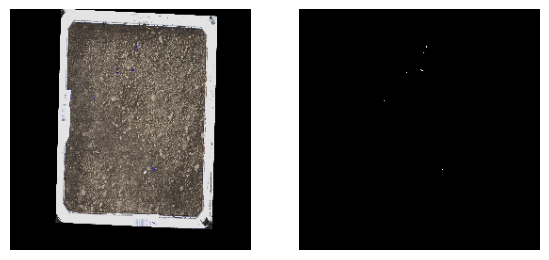

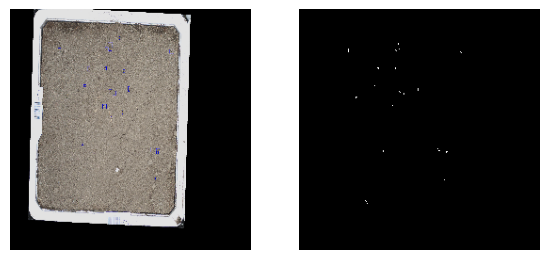

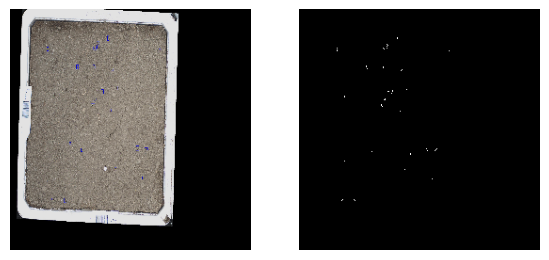

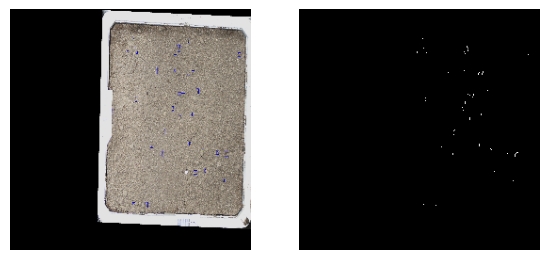

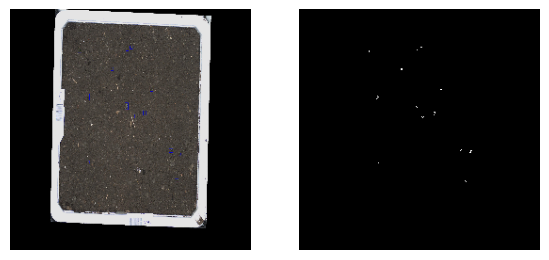

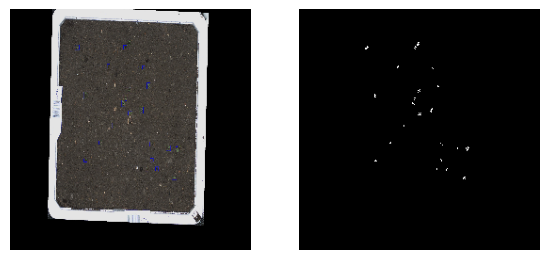

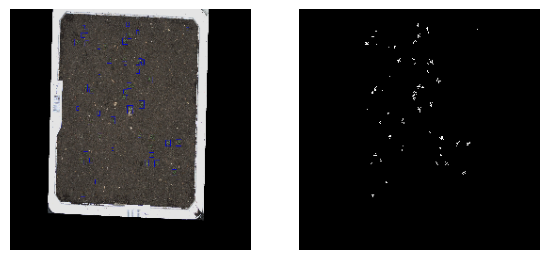

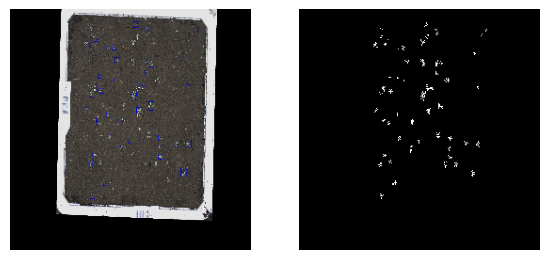

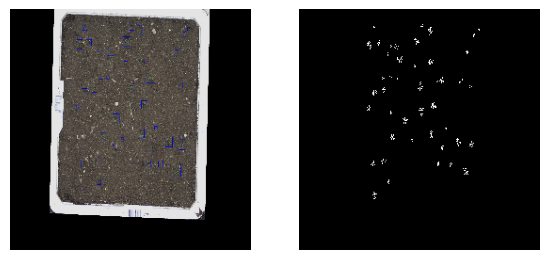

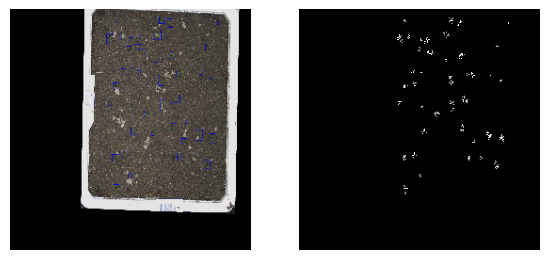

<Figure size 1800x1800 with 0 Axes>

In [31]:
def showing(ds, img_num, row):
    for idx, (im, gt) in enumerate(ds):
        count = 1
        plt.figure(figsize=(18, 18))
        if idx == 10: 
            break
        im = (im * 255).detach().cpu().permute(1, 2, 0).numpy().astype('uint8')
        gt = (gt * 255).detach().cpu().squeeze().numpy().astype('uint8')  
        
        plt.subplot(row, img_num // row, count)
        plt.imshow(im)
        plt.axis('off')
        count += 1
        plt.subplot(row, img_num // row, count)
        plt.imshow(gt, cmap='gray')  
        plt.axis('off')
        count += 1
        plt.show()
showing(ds, 10, 2)

In [32]:
def get_dl(root, transformations, bs, split = [0.7, 0.15, 0.15]):
    
    assert sum(split) == 1
    # Get dataset
    ds = Segmentations(root='/kaggle/input/plant-semantic-segmentation/Plant segmentation', transformations=tfs)
    
    tr_len = int(split[0] * len(ds))
    val_len = int(split[1] * len(ds))
    test_len = len(ds) - (tr_len + val_len)
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    
    print(f"There are {len(tr_ds)} images in the trainset")
    print(f"There are {len(val_ds)} images in the validation set")
    print(f"There are {len(test_ds)} images in the test set")
    
    tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False)
    
    print(len(tr_dl))
    print(len(val_dl))
    print(len(test_dl))
    
    
    return tr_dl, val_dl, test_dl 


    
tr_dl, val_dl, test_dl = get_dl(root = "data", bs = 4, transformations = tfs) 

There are 144 images and 144 masks in the dataset
There are 100 images in the trainset
There are 21 images in the validation set
There are 23 images in the test set
25
6
23


In [33]:
class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 3e-4, n_cls = 2):
        
        
        self.pred_ = pred # to compute loss value
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1)), gt 
        self.pred, self.gt = torch.argmax(torch.nn.functional.softmax(pred, dim = 1), dim = 1), gt 
        self.loss_fn, self.eps, self.n_cls = loss_fn, eps, n_cls
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) # (3, 224, 224) -> (3 * 224 * 224)

    def PA(self):
        
        with torch.no_grad():
            
            match = torch.eq(self.pred, self.gt).int()
            
        return float(match.sum()) / float(match.numel()) # numel() is a number of elements in match
    
    def mIoU(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            
            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt   == c
                
                # If there is no background class
                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                
                else:
                    
                    intersection = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    
                    iou = (intersection) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, self.gt)

In [34]:
model = smp.Unet(encoder_name = 'resnet18',
               encoder_weights = 'imagenet',
               in_channels = 3,
               classes = 2,
               encoder_depth = 5,
               decoder_channels = [256,128,64,32,16])

In [35]:
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

In [36]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, loss_fn, opt, epochs, device, patience):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss = torch.tensor(float("inf"))
    not_improved = 0
    #os.makedirs("saved_models", exist_ok = True)
    
    model.to(device)
    for epoch in range(1, epochs + 1):  
        
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        
        print(f"{epoch}-epoch train is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            
            pred = model(im)
            
            met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)
            
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            tr_pa_ += met.PA()
            tr_loss_ += loss_
            
            loss_.backward() 
            opt.step() 
            opt.zero_grad()
            
        print(f"{epoch}-epoch train is finished!")
        print(f"{epoch}-epoch validation is started...")
        
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):
            
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred = model(im)

                met = Metrics(pred = pred, gt = gt, loss_fn = loss_fn)

                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                val_loss_ += met.loss().item()
            
        print(f"{epoch}-epoch validation is finished!")
        
        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len
        
        val_loss_ /= val_len
        val_iou_ /= val_len
        val_pa_ /= val_len
        
        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} Train Process Results: \n")
        print(f"Train loss          -> {tr_loss_:.3f}")
        print(f"Train PA            -> {tr_pa_:.3f}")
        print(f"Train mIoU          -> {tr_iou_:.3f}")
        print(f"Validation loss     -> {val_loss_:.3f}")
        print(f"Validation PA       -> {val_pa_:.3f}")
        print(f"Validation mIoU     -> {val_iou_:.3f}")
        
        tr_loss.append(tr_loss_); tr_pa.append(tr_pa_); tr_iou.append(tr_iou_)
        val_loss.append(val_loss_); val_pa.append(val_pa_); val_iou.append(val_iou_)
        
        if best_loss < val_loss_:
            print(f"Loss value did not decrease")
            not_improved += 1
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break
        
        else:
            print(f"Loss decreased from {best_loss} to {val_loss_}")
            best_loss = val_loss_
            torch.save(model, "/kaggle/working/_best_model.pth")
                        
    return{"tr_loss": tr_loss, "tr_pa": tr_pa, "tr_iou": tr_iou,
              "val_loss": val_loss, "val_pa": val_pa, "val_iou": val_iou} 



In [37]:
his = train(model = model, tr_dl = tr_dl,
            val_dl = val_dl, loss_fn = loss_fn,
            opt = opt, epochs = 10, device = "cpu",
             patience = 4)

1-epoch train is started...


100%|██████████| 25/25 [01:43<00:00,  4.14s/it]


1-epoch train is finished!
1-epoch validation is started...


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]


1-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 Train Process Results: 

Train loss          -> 0.279
Train PA            -> 0.948
Train mIoU          -> 0.481
Validation loss     -> 0.216
Validation PA       -> 0.963
Validation mIoU     -> 0.481
Loss decreased from inf to 0.21616255988677344
2-epoch train is started...


100%|██████████| 25/25 [01:42<00:00,  4.10s/it]


2-epoch train is finished!
2-epoch validation is started...


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


2-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 Train Process Results: 

Train loss          -> 0.147
Train PA            -> 0.965
Train mIoU          -> 0.484
Validation loss     -> 0.118
Validation PA       -> 0.963
Validation mIoU     -> 0.482
Loss decreased from 0.21616255988677344 to 0.1176005316277345
3-epoch train is started...


100%|██████████| 25/25 [01:42<00:00,  4.11s/it]


3-epoch train is finished!
3-epoch validation is started...


100%|██████████| 6/6 [00:15<00:00,  2.62s/it]


3-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 Train Process Results: 

Train loss          -> 0.101
Train PA            -> 0.965
Train mIoU          -> 0.488
Validation loss     -> 0.087
Validation PA       -> 0.963
Validation mIoU     -> 0.485
Loss decreased from 0.1176005316277345 to 0.08673659339547157
4-epoch train is started...


100%|██████████| 25/25 [01:42<00:00,  4.08s/it]


4-epoch train is finished!
4-epoch validation is started...


100%|██████████| 6/6 [00:16<00:00,  2.69s/it]


4-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 Train Process Results: 

Train loss          -> 0.080
Train PA            -> 0.965
Train mIoU          -> 0.501
Validation loss     -> 0.076
Validation PA       -> 0.964
Validation mIoU     -> 0.496
Loss decreased from 0.08673659339547157 to 0.07596019965906937
5-epoch train is started...


100%|██████████| 25/25 [01:42<00:00,  4.12s/it]


5-epoch train is finished!
5-epoch validation is started...


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


5-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 Train Process Results: 

Train loss          -> 0.070
Train PA            -> 0.966
Train mIoU          -> 0.508
Validation loss     -> 0.067
Validation PA       -> 0.964
Validation mIoU     -> 0.504
Loss decreased from 0.07596019965906937 to 0.0672231496622165
6-epoch train is started...


100%|██████████| 25/25 [01:43<00:00,  4.13s/it]


6-epoch train is finished!
6-epoch validation is started...


100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


6-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 Train Process Results: 

Train loss          -> 0.063
Train PA            -> 0.966
Train mIoU          -> 0.514
Validation loss     -> 0.064
Validation PA       -> 0.964
Validation mIoU     -> 0.509
Loss decreased from 0.0672231496622165 to 0.06370321350793044
7-epoch train is started...


100%|██████████| 25/25 [01:41<00:00,  4.07s/it]


7-epoch train is finished!
7-epoch validation is started...


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


7-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 Train Process Results: 

Train loss          -> 0.059
Train PA            -> 0.966
Train mIoU          -> 0.517
Validation loss     -> 0.062
Validation PA       -> 0.964
Validation mIoU     -> 0.518
Loss decreased from 0.06370321350793044 to 0.06175317118565241
8-epoch train is started...


100%|██████████| 25/25 [01:42<00:00,  4.10s/it]


8-epoch train is finished!
8-epoch validation is started...


100%|██████████| 6/6 [00:16<00:00,  2.67s/it]


8-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 Train Process Results: 

Train loss          -> 0.057
Train PA            -> 0.966
Train mIoU          -> 0.521
Validation loss     -> 0.060
Validation PA       -> 0.964
Validation mIoU     -> 0.519
Loss decreased from 0.06175317118565241 to 0.06026892736554146
9-epoch train is started...


100%|██████████| 25/25 [01:49<00:00,  4.39s/it]


9-epoch train is finished!
9-epoch validation is started...


100%|██████████| 6/6 [00:16<00:00,  2.83s/it]


9-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 Train Process Results: 

Train loss          -> 0.054
Train PA            -> 0.966
Train mIoU          -> 0.525
Validation loss     -> 0.057
Validation PA       -> 0.964
Validation mIoU     -> 0.517
Loss decreased from 0.06026892736554146 to 0.05659373911718527
10-epoch train is started...


100%|██████████| 25/25 [01:50<00:00,  4.43s/it]


10-epoch train is finished!
10-epoch validation is started...


100%|██████████| 6/6 [00:16<00:00,  2.79s/it]


10-epoch validation is finished!

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 Train Process Results: 

Train loss          -> 0.053
Train PA            -> 0.966
Train mIoU          -> 0.526
Validation loss     -> 0.055
Validation PA       -> 0.964
Validation mIoU     -> 0.523
Loss decreased from 0.05659373911718527 to 0.05521677869061629


# Plot

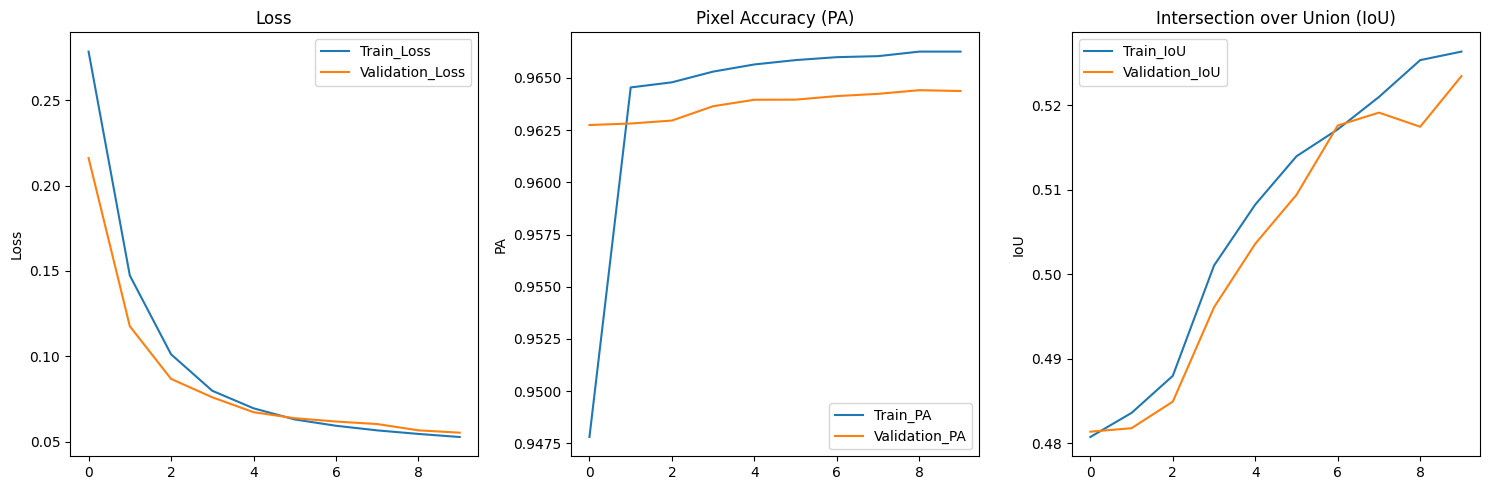

In [38]:
def plot_results(his):
    tr_loss = [loss.item() for loss in his['tr_loss']]
    tr_pa = his["tr_pa"]
    tr_iou = his["tr_iou"]
    val_loss = his["val_loss"]
    val_pa = his["val_pa"]
    val_iou = his["val_iou"]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(tr_loss, label="Train_Loss")
    plt.plot(val_loss, label="Validation_Loss")
    plt.title("Loss")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(tr_pa, label="Train_PA")
    plt.plot(val_pa, label="Validation_PA")
    plt.title("Pixel Accuracy (PA)")
    plt.ylabel("PA")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(tr_iou, label="Train_IoU")
    plt.plot(val_iou, label="Validation_IoU")
    plt.title("Intersection over Union (IoU)")
    plt.ylabel("IoU")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_results(his)

# Inference

In [39]:
device = "cpu"

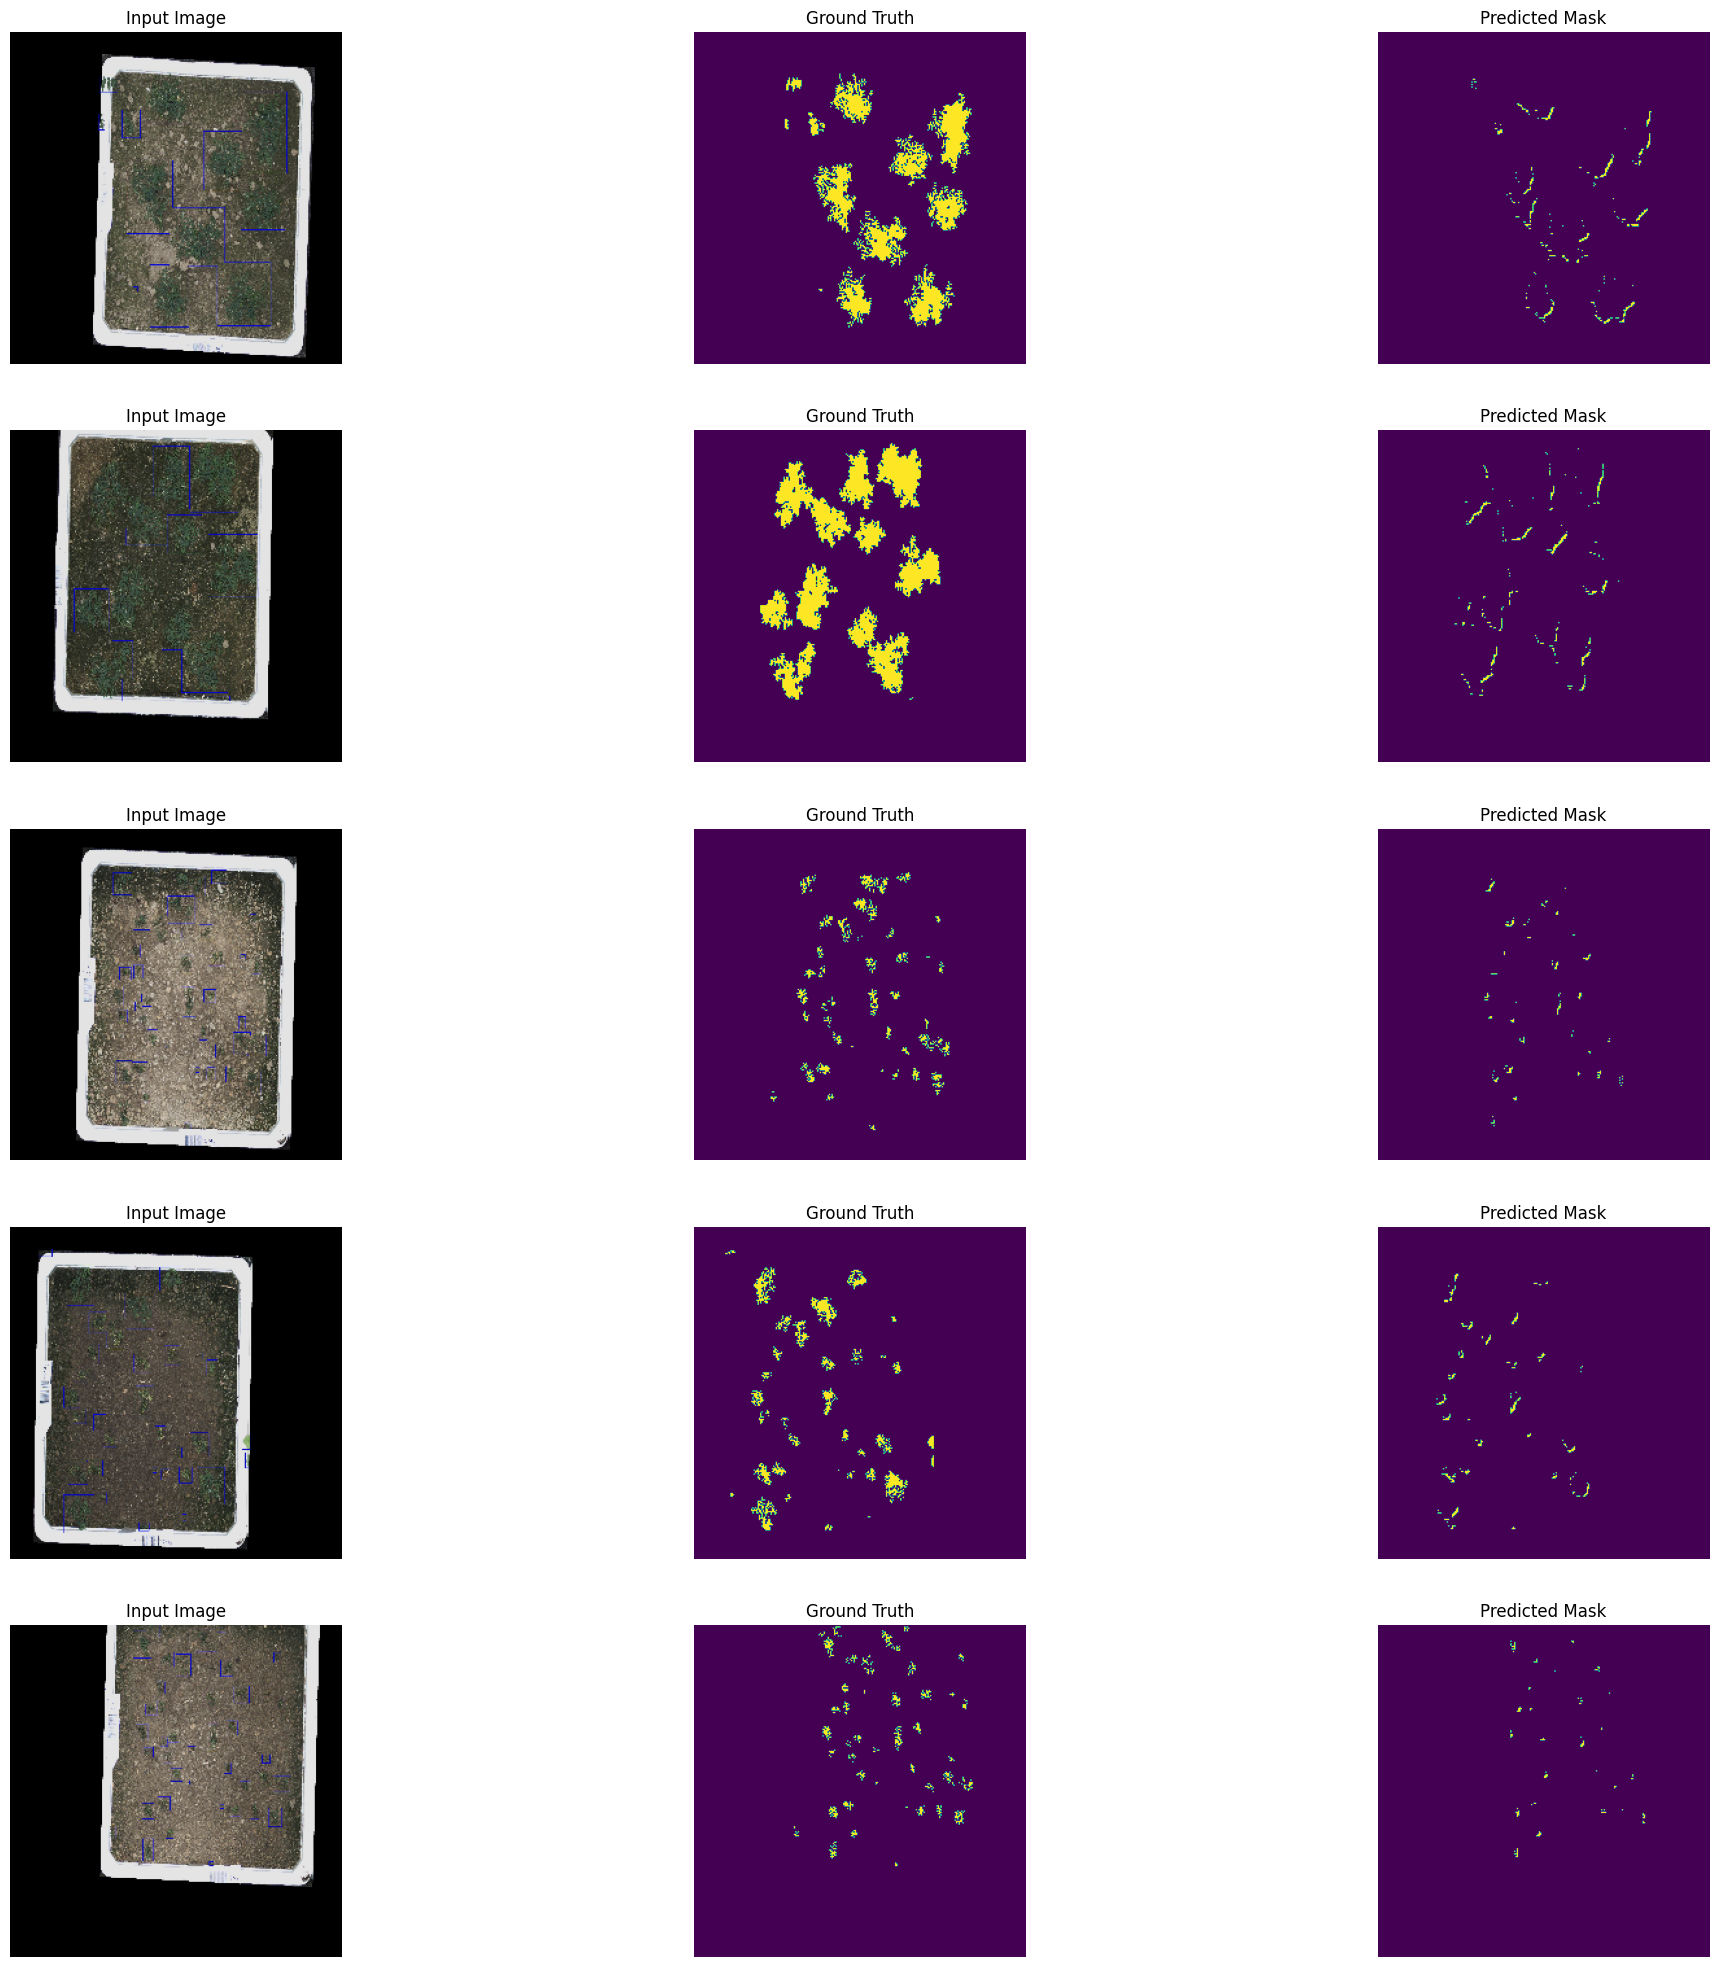

In [41]:
def inference(dl, model, device, n_ims=15):
    cols = 3
    rows = (n_ims + cols - 1) // cols 

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data
        # Get predicted mask
        with torch.no_grad():
            pred = torch.argmax(model(im.to(device)), dim=1)
        ims.append(im.cpu().numpy())
        gts.append(gt.cpu().numpy())
        preds.append(pred.cpu().numpy())

    plt.figure(figsize=(25, 25))
    while count <= n_ims:  
        for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
            
            if count > n_ims:
                break
            plt.subplot(rows, cols, count)
            plt.imshow(im[0].transpose(1, 2, 0))
            plt.title("Input Image")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(gt[0])
            plt.title("Ground Truth")
            plt.axis('off')
            count += 1

            plt.subplot(rows, cols, count)
            plt.imshow(pred[0])
            plt.title("Predicted Mask")
            plt.axis('off')
            count += 1

    plt.show()

model = torch.load("/kaggle/working/_best_model.pth")
inference(test_dl, model=model, device=device)